## Imports

In [1]:
# %pip install numpy pandas matplotlib scikit-learn seaborn cufflinks xgboost plotly lightgb imbalanced-learn geopandas

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cufflinks as cf
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

import plotly.graph_objects as px


# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='ggplot',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
# plt.style.use('light_background')

# Set Pandas to display all columsn
pd.set_option("display.max.columns", None)
sns.set_palette("husl")  # Set the color palette


# Dataset Overview

### 01. Load the dataset

In [3]:
dataset = pd.read_csv('data_preprocessing/yield_df.csv', encoding='utf-8', index_col=[0])
dataset = dataset.rename(columns={'hg/ha_yield': 'Crop Yield (hg/ha)', 'Item': 'Crop', 'average_rain_fall_mm_per_year': 'Rainfall (mm/year)', 'pesticides_tonnes': 'Pesticides (tonnes)', 'avg_temp': 'Temperature (Celsius)'})

# Data Preprocessing

### 02. Handle Categorical Variables

In [4]:
# Handle categorical variables
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# fit and transform the categorical data in Area and Item
encoded_data = encoder.fit_transform(dataset[["Crop", 'Area']])

# convert the encoded data back into a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(["Crop", 'Area']))
df = pd.concat([dataset, encoded_df], axis=1)

### 03. Remove Unnecesary Features

In [5]:
# Create features and labels (and remove categorical variables)
features = df.drop(['Crop Yield (hg/ha)',"Crop",'Area', 'Rainfall (mm/year)'], axis=1)
labels = df['Crop Yield (hg/ha)']

### 04. Split Dataset

In [6]:
# Create training (80%) and test (20%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.2, random_state=42)
# features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

print(f'Train: {len(features_train)} features, {len(labels_train)} labels\
      \nTest: {len(features_test)} features, {len(labels_test)} labels')
    # \nVal: {len(features_val)} features, {len(labels_val)} labels\')

Train: 22593 features, 22593 labels      
Test: 5649 features, 5649 labels


# Functions

#### Checking Parameters

In [7]:
def parameter_check_class(pred, labels_test, features_test):
    """Determines R2, MAE, RMSE and Adjusted R2 by CLASS"""
    ft_copy = features_test.copy()
    lt_copy = labels_test.copy()
    # Calculate R^2 and MAE for each class
    r2_scores = {}
    mae_scores = {}
    mae_per_scores = {}
    
    # Reconvert Items feature into a categorical variable
    item_cols = [col for col in ft_copy.columns if col.startswith('Crop_')]
    ft_copy['Crop'] = ft_copy[item_cols].idxmax(axis=1).str.replace('Crop_', '')
    # Drop the one-hot encoded columns
    ft_copy.drop(item_cols, axis=1, inplace=True)
    
    # Reset index so they match
    ft_copy = ft_copy.reset_index(drop=True)
    lt_copy = lt_copy.reset_index(drop=True)
    
    print('\n')
    # Group features by crop type
    for crop, group in ft_copy.groupby(['Crop']):
        idx = group.index.tolist()
        y_true = lt_copy.loc[idx].to_numpy()
        r2 = r2_score(y_true, pred[idx])
        mae = mean_absolute_error(y_true, pred[idx])

        # Calculate the percentage mae
        target_range = max(y_true) - min(y_true)
        percentage_mae = (mae / target_range) * 100

        mae_per_scores[crop] = percentage_mae
        r2_scores[crop] = r2
        mae_scores[crop] = mae

        # print the results
        print(f"{crop}: R^2={r2:.2f}, MAE={mae:.2f}, MAE%={percentage_mae:.2f}%")

    return { 'r2': r2_scores, 'mae':mae_scores, 'mae%': mae_per_scores}

In [8]:
def parameter_check(pred, labels_test):
    """Determines r2, mae, rmse and adjusted r2"""

    # Calculate R-squared
    r2 = r2_score(labels_test , pred)
    print(f"R^2: {r2:.3f}")

    # Calculate MAE
    mae = mean_absolute_error(labels_test, pred)
    print(f"MAE: {mae:.3f}")

    # calculate the percentage mae
    target_range = max(labels_test) - min(labels_test)
    percentage_mae = (mae / target_range) * 100
    print(f"MAE(%): {percentage_mae:.2f}%")

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(labels_test, pred))
    print(f"RMSE {rmse:.3f}")

    # Calculate Adjusted R-squared
    n = len(labels_test)
    p = len(pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"Adjusted R^2 {adj_r2:.3f}")

    return { 'r2': r2, 'mae':mae, 'rmse':rmse, 'adj_r2':adj_r2, 'mae%': percentage_mae}

In [9]:
def plot_learning_curves(best_model, features_train, labels_train, cv, title):
    """Plot the learning curve of a model"""
    
    train_sizes, train_scores, val_scores = learning_curve(best_model, features_train, labels_train, 
                cv=cv, n_jobs=-1, shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="hotpink")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="hotpink",
            label="Train")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="blue",
            label="Val")
    plt.title(f'Model {title}')
    plt.legend(loc="best")
    plt.show()

### 05. Paramter Grid

### Hyperparameters

In [10]:
# Parameter grids to search over using gridsearch
params = {
    'rgs__n_estimators': [100,200,300],
    'rgs__max_depth': [3, 6, 12],
    'rgs__learning_rate': [0.05, 0.1, 0.20],
    'rgs__min_child_weight': [1, 10],
    'rgs__gamma' : [0,0.1,0.5],
    'rgs__reg_alpha' : [0, 0.1, 0.5],
    'rgs__reg_lambda': [0, 0.1, 0.5],
}

In [35]:
pd.DataFrame.from_dict(params, orient='index')

,0,1,2
rgs__n_estimators,300.00,NaN,NaN
rgs__max_depth,3.00,6.0,12.0
rgs__learning_rate,0.05,0.1,0.2
rgs__min_child_weight,1.00,10.0,NaN
rgs__gamma,0.00,0.1,0.5
rgs__reg_alpha,0.00,0.1,0.5
rgs__reg_lambda,0.00,0.1,0.5


### Pipeline

In [11]:
def build_pipeline(params, regressor, features_train, labels_train, features_test, labels_test):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('rgs', regressor)
    ])

    # Cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    # Set up the grid search
    gs = GridSearchCV(estimator=pipe,param_grid=params,n_jobs=-1, verbose=10, cv=cv,scoring='r2')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Plot learning curves
    plot_learning_curves(gs.best_estimator_, features_train, labels_train, cv, 'XGBRegressor()')
    
    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)
    best_par_class = parameter_check_class(labels_preds, labels_test, features_test)
    
    return best_par, best_par_class, gs_results 

# Model Training

### 06. Hyperparameter Tuning

X-Gradient Boost

Fitting 15 folds for each of 486 candidates, totalling 7290 fits


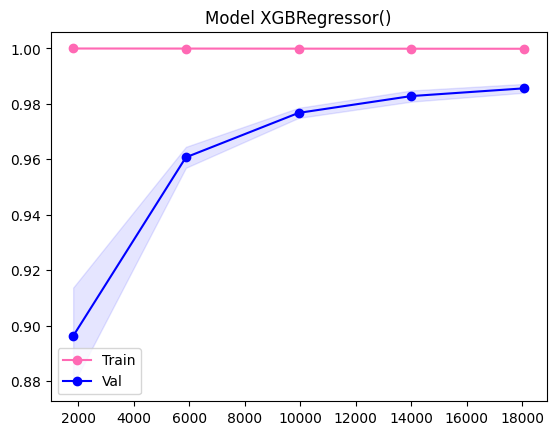

Best score: 0.9857008649293898
Best parameters: 
{'rgs__gamma': 0.5, 'rgs__learning_rate': 0.2, 'rgs__max_depth': 12, 'rgs__min_child_weight': 1, 'rgs__n_estimators': 300, 'rgs__reg_alpha': 0.5, 'rgs__reg_lambda': 0.5}

Score: 0.988286079155458
R^2: 0.988
MAE: 3661.640
MAE(%): 0.76%
RMSE 9217.860
Adjusted R^2 67.160


Cassava: R^2=0.99, MAE=4798.50, MAE%=1.29%
Maize: R^2=0.97, MAE=2404.51, MAE%=1.92%
Plantains and others: R^2=0.92, MAE=8117.96, MAE%=2.04%
Potatoes: R^2=0.97, MAE=8693.65, MAE%=1.84%
Rice, paddy: R^2=0.96, MAE=2102.58, MAE%=2.12%
Sorghum: R^2=0.94, MAE=1872.06, MAE%=2.48%
Soybeans: R^2=0.91, MAE=1195.22, MAE%=2.89%
Sweet potatoes: R^2=0.98, MAE=4859.90, MAE%=1.44%
Wheat: R^2=0.95, MAE=2046.19, MAE%=2.13%
Yams: R^2=0.99, MAE=3473.81, MAE%=1.63%


In [12]:
best_par_xgb, best_par_xgb_class, score_xgb = build_pipeline(params, xgb.XGBRegressor(), features_train, labels_train, features_test, labels_test)

In [31]:
pd.DataFrame.from_dict(best_par_xgb, orient='index', columns=['Model']).T

,r2,mae,rmse,adj_r2,mae%
Model,0.988286,3661.640046,9217.8598,67.160225,0.75692


In [29]:
pd.DataFrame.from_dict(best_par_xgb_class, orient='index').T


,r2,mae,mae%
Cassava,0.985485,4798.499921,1.285193
Maize,0.970338,2404.510434,1.916632
Plantains and others,0.924819,8117.963816,2.044029
Potatoes,0.965109,8693.647797,1.841340
"Rice, paddy",0.962729,2102.583525,2.116531
Sorghum,0.943424,1872.056600,2.482109
Soybeans,0.908057,1195.223740,2.886386
Sweet potatoes,0.976809,4859.903446,1.435425
Wheat,0.951262,2046.192248,2.126444
Yams,0.986989,3473.810883,1.626925
